# **Dell Service Center Data cleaning and Analysis :-**
---

This notebook is divided into 3 parts




1. Data Cleaning
2. Feature Engineering
3. Data Analysis

# 1. Data Cleaning

Import basic libraries for the notebook

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.pyplot import figure
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

Importing .csv data and storing in dataframe.
Also, created image of the csv file to keep original copy

In [2]:
# read the data
df = pd.read_csv("/content/drive/MyDrive/Datasets/DellGSPE_DSrole_dataset.csv", sep=',')

df_org = df.copy()

FileNotFoundError: [Errno 2] File /content/drive/MyDrive/Datasets/DellGSPE_DSrole_dataset.csv does not exist: '/content/drive/MyDrive/Datasets/DellGSPE_DSrole_dataset.csv'

In [3]:
# shape and data types of the dataset
print(df.shape)
print(df.dtypes)

(100000, 19)
asst_id                  int64
product_type            object
mnfture_wk               int64
contract_st              int64
contract_end             int64
contact_wk               int64
contact_type            object
issue_type              object
topic_category          object
parts_sent              object
repair_type             object
repeat_ct                int64
parts_ct                 int64
agent_tenure_indays    float64
contact_manager_flg      int64
diagnostics             object
repeat_parts_sent       object
region                  object
country                 object
dtype: object





Extracting numerical and Categorical columns for further manipulation

In [4]:
# select the numerical columns

df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print(numeric_cols)

['asst_id' 'mnfture_wk' 'contract_st' 'contract_end' 'contact_wk'
 'repeat_ct' 'parts_ct' 'agent_tenure_indays' 'contact_manager_flg']


In [5]:
# select non numeric columns

df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print(non_numeric_cols)

['product_type' 'contact_type' 'issue_type' 'topic_category' 'parts_sent'
 'repair_type' 'diagnostics' 'repeat_parts_sent' 'region' 'country']


Initial analysis of the missing data by columns,

We can see that 5 columns have missing values which needs to be filled in for unbiased data analysis

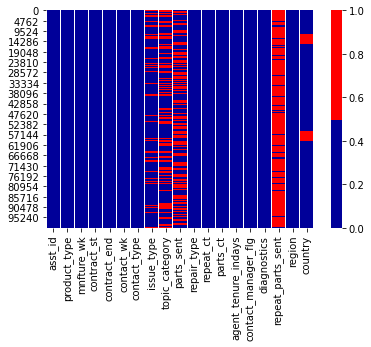

In [6]:
cols = df.columns[:19]
colors = ['#000099','#FF0000'] # Blue for missung data and Red is not missing

sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

In [7]:
# Percentage of missing data by columns

for col in df.columns:
  pct_missing = np.mean(df[col].isnull())
  print('{} - {}%'.format(col, round(pct_missing*100)))


asst_id - 0%
product_type - 0%
mnfture_wk - 0%
contract_st - 0%
contract_end - 0%
contact_wk - 0%
contact_type - 0%
issue_type - 14%
topic_category - 33%
parts_sent - 45%
repair_type - 0%
repeat_ct - 0%
parts_ct - 0%
agent_tenure_indays - 0%
contact_manager_flg - 0%
diagnostics - 0%
repeat_parts_sent - 87%
region - 0%
country - 10%


• Calculated number of missing values by row,

• This helps to remove lines when certain rows have more number of missing values than pre-defined threshold.

• In our case we have few records where maximum of 6 columns have blank. But we will not drop these lines as we will try to fill these blank values first

created missing indicator for: product_type
created missing indicator for: contact_type
created missing indicator for: issue_type
created missing indicator for: topic_category
created missing indicator for: parts_sent
created missing indicator for: agent_tenure_indays
created missing indicator for: repeat_parts_sent
created missing indicator for: region
created missing indicator for: country


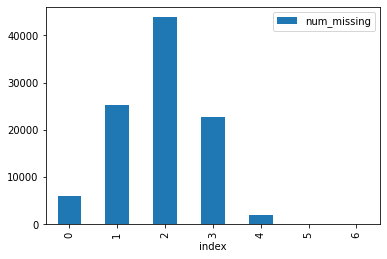

In [8]:
# Finding number of missing values by rows

for col in df.columns:
  missing = df[col].isnull()
  num_missing = np.sum(missing)

  if num_missing > 0:
    print('created missing indicator for: {}'.format(col))
    df['{}_ismissing'.format(col)] = missing

  

# Adding missing values by row to compute missing values by row

ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')



• Columns "Repeat_parts_sent" and "parts_sent" have valid blank values. These blank values tells that no "parts" are sent for this repair record. Hence, blank values cannot be replaced by "mode" function. I replaced and filled these values with "NOT_USED" string

*   I also found some duplicate records which I have deleted from the dataframe



In [9]:
#Replacing missing values


df['repeat_parts_sent'] = df['repeat_parts_sent'].fillna('NOT_USED')
df['parts_sent'] = df['parts_sent'].fillna('NOT_USED')

df = df.drop_duplicates().reset_index()

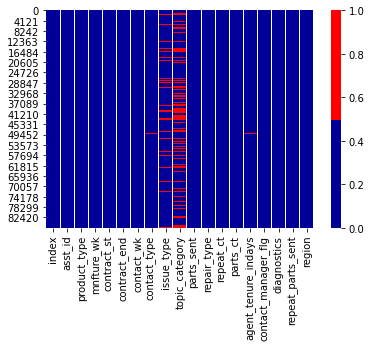

In [10]:
cols = df.columns[:19]
colors = ['#000099','#FF0000'] # Blue for missung data and Red is not missing

sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

In [11]:
df.head()

,index,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type,topic_category,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country,product_type_ismissing,contact_type_ismissing,issue_type_ismissing,topic_category_ismissing,parts_sent_ismissing,agent_tenure_indays_ismissing,repeat_parts_sent_ismissing,region_ismissing,country_ismissing,num_missing
0,0,0,Laptops,201726,201726,202125,201840,Voice,NaN,NaN,"Hard Drive, Documentation(2)",Hard,0,3,1018.0,0,Not_USED,NOT_USED,Hogwarts,NaN,False,False,True,True,False,False,True,False,True,4
1,1,1,Laptops,201650,201650,201949,201840,Voice,NaN,NaN,"Speaker, Chassis",Hard,0,2,1018.0,0,Not_USED,NOT_USED,Hogwarts,Zonko's Joke Shop,False,False,True,True,False,False,True,False,False,3
2,2,2,Laptops,201821,201821,202222,201840,Voice,NaN,NaN,Cables,Hard,0,1,1018.0,0,Not_USED,"Motherboard, Miscellaneous(2), Hard Drive, Cha...",Hogwarts,Zonko's Joke Shop,False,False,True,True,False,False,False,False,False,2
3,3,3,Laptops,201608,201608,201908,201840,VOICE,Hard Drive,Booting,Hard Drive,Hard,0,1,298.0,0,Effective_Usage,NOT_USED,Hogwarts,Zonko's Joke Shop,False,False,False,False,False,False,True,False,False,1
4,4,4,Laptops,201732,201732,202032,201840,Voice,NaN,NaN,Battery (Notebook),Hard,0,1,1018.0,0,Not_USED,NOT_USED,Hogwarts,Zonko's Joke Shop,False,False,True,True,False,False,True,False,False,3


**Next Step is cleaning columns "issue_type" and "topic_category"**

*   From initial data analysis, I found that "issue_type", "topic_category" and "parts_sent" are dependent/correlated columns
*   In multiple occurrences, these 3 columns have same combination of the values 
*   Hence, we can derive the values of "issue_type" and "topic_category" from column "parts_sent"
*   To achieve this I tried using multivariate imputers to achieve best classification for the missing values
*   For starters, I used KNN Imputer and iterative imputer functions on the data
*   One of the issue I faced while doing this is, classes are not correctly identified by the most frequent observations. Also, These imputer better work for numerical columns (In our case, we have categorical features)
*   I have commented the code where I tried implementing KNN Imputer but results were having wrong data filled in missing cells 












In [12]:
'''
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

df_1 = df.copy()

df_1 = df_1[["issue_type", "topic_category", "parts_sent"]]

mm = MinMaxScaler()

def find_category_mappings(df_1, variable):
    return {k: i for i, k in enumerate(df_1[variable].dropna().unique(), 0)}

def integer_encode(df_1 , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df_1 = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df_1, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df_1, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df_1)
    knn_imputer = IterativeImputer()
    knn = knn_imputer.fit_transform(sca)
    df_1.iloc[:,:] = mm.inverse_transform(knn)
    for i in df_1.columns : 
        df_1[i] = round(df_1[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df_1[i] = df_1[i].map(inv_map)
    return df


#Imputation
imputation(df_1,['issue_type', 'topic_category'])
'''


'\nimport numpy as np\nimport pandas as pd\nfrom sklearn.impute import KNNImputer\nfrom sklearn.preprocessing import MinMaxScaler\nfrom sklearn.experimental import enable_iterative_imputer \nfrom sklearn.impute import IterativeImputer\n\ndf_1 = df.copy()\n\ndf_1 = df_1[["issue_type", "topic_category", "parts_sent"]]\n\nmm = MinMaxScaler()\n\ndef find_category_mappings(df_1, variable):\n    return {k: i for i, k in enumerate(df_1[variable].dropna().unique(), 0)}\n\ndef integer_encode(df_1 , variable, ordinal_mapping):\n    df[variable] = df[variable].map(ordinal_mapping)\n\nmappin = dict()\ndef imputation(df1 , cols):\n    df_1 = df1.copy()\n    #Encoding dict &amp; Removing nan    \n    #mappin = dict()\n    for variable in cols:\n        mappings = find_category_mappings(df_1, variable)\n        mappin[variable] = mappings\n\n    #Apply mapping\n    for variable in cols:\n        integer_encode(df_1, variable, mappin[variable])  \n\n    #Minmaxscaler and KNN imputation \n    sca = mm.

**Alternative for the Mutivariate Imputers to fill missing values - (Manual)**

*   I grouped the 'part_sent' with the columns which we are trying to fill values
*   After grouping I found the top occurrence of "issue_type" and "topic_cateory" for each value of 'part_Sent'
*   Then I merged/ left joined the occurrence with our main data set
*   Replaced the values from main dataset columns where values are missing
*   This part took lot of iteration of finding correct way to fill the data as this is most important columns in our analysis
*   Further cleaning can be done towards multiple combinations and can take mutiple column to find max occurrences of the different combinations. Due to time constraint I could not do everything.














In [13]:
df_r = df[['asst_id','parts_sent', 'issue_type']]

df_tc = df[['asst_id','parts_sent', 'topic_category']]

#df_g = df_r.groupby(['issue_type', 'parts_sent']).size().groupby(level=0).idxmax().apply(lambda x: x[1]).reset_index(name='parts_sent')

s = df_r.groupby(['parts_sent','issue_type']).size()
df_g = s.loc[s.groupby(level=0).idxmax()].reset_index().drop(0,axis=1) #finding top occurences of the 'issue_type' for each 'parts_sent' column values

df_g.columns = ['parts_sent','issue_type_1']

df_g.loc[df_g['parts_sent'] == 'NOT_USED', 'issue_type_1'] = 'Information Request' # There are some rows with values of "NOT_sent" which cannot be used to derive the "issue_type". 
#Hence, defaulting it to the most general category 'Information Request' 

left_join_1 = pd.merge(df, df_g, on = 'parts_sent', how ='left') #merging (Left join the most common issue types with original dataset)

df = left_join_1[['asst_id', 'product_type', 'mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk', 'contact_type', 'issue_type', 'issue_type_1', 'topic_category',
       'parts_sent', 'repair_type', 'repeat_ct', 'parts_ct',
       'agent_tenure_indays', 'contact_manager_flg', 'diagnostics',
       'repeat_parts_sent', 'region', 'country']]

df['issue_type'] = np.where(df['issue_type'].isnull(), df['issue_type_1'], df['issue_type']) #replacing null values with merger column.


# Performed same steps to identify missing Topic_Category from top occurences of the 'Topic_category' by 'parts_sent' column
tc = df_tc.groupby(['parts_sent', 'topic_category']).size()
df_k = tc.loc[tc.groupby(level=0).idxmax()].reset_index().drop(0,axis=1)


df_k.columns = ['parts_sent','topic_category_1']

left_join_2 = pd.merge(df, df_k, on = 'parts_sent', how ='left')

df = left_join_2[['asst_id', 'product_type', 'mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk', 'contact_type', 'issue_type', 'issue_type_1', 'topic_category', 'topic_category_1',
       'parts_sent', 'repair_type', 'repeat_ct', 'parts_ct',
       'agent_tenure_indays', 'contact_manager_flg', 'diagnostics',
       'repeat_parts_sent', 'region', 'country']]

df['topic_category']= np.where(df['topic_category'].isnull(), df['topic_category_1'], df['topic_category'])


# Performed same steps to identify missing 'Country' values from top occurences of the 'countries' by 'region' column.
# This tricky as region definations can be different for different organizations.
# Some regions can go across countries or regions can be defined within single country as well
# For this notebook, I have considered regions go across to countries

df_country = df[['region', 'country']]

con = df_country.groupby(['region', 'country']).size()
df_con = con.loc[con.groupby(level=0).idxmax()].reset_index().drop(0,axis=1)


df_con.columns = ['region', 'country_1']

left_join_3 = pd.merge(df, df_con, on = 'region', how ='left')

df = left_join_3[['asst_id', 'product_type', 'mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk', 'contact_type', 'issue_type', 'issue_type_1', 'topic_category', 'topic_category_1',
       'parts_sent', 'repair_type', 'repeat_ct', 'parts_ct',
       'agent_tenure_indays', 'contact_manager_flg', 'diagnostics',
       'repeat_parts_sent', 'region', 'country', 'country_1']]

df['country']= np.where(df['country'].isnull(), df['country_1'], df['country'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


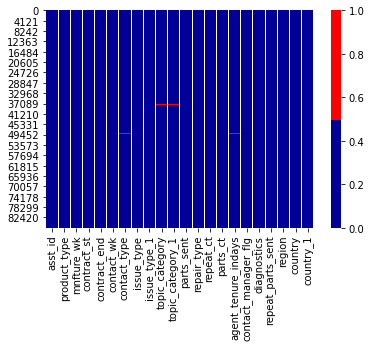

In [14]:
cols = df.columns[:22]
colors = ['#000099','#FF0000'] # Yellow for missung data and Red is not missing

sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colors))

In [ ]:
#not required

# left_join.to_csv('/content/drive/MyDrive/Datasets/left_data.csv', index = False)

In [15]:
df = df.drop(['issue_type_1','topic_category_1','country_1'], axis=1)

Need to drop rows with missing values

In [16]:
# Droping rows with missing issue_type and topic category

df = df.dropna()
#df = df.drop_duplicates()


In [17]:
for col in df.columns:
  pct_missing = np.mean(df[col].isnull())
  print('{} - {}%'.format(col, round(pct_missing*100)))

asst_id - 0%
product_type - 0%
mnfture_wk - 0%
contract_st - 0%
contract_end - 0%
contact_wk - 0%
contact_type - 0%
issue_type - 0%
topic_category - 0%
parts_sent - 0%
repair_type - 0%
repeat_ct - 0%
parts_ct - 0%
agent_tenure_indays - 0%
contact_manager_flg - 0%
diagnostics - 0%
repeat_parts_sent - 0%
region - 0%
country - 0%


In [ ]:
df

,asst_id,product_type,mnfture_wk,contract_st,contract_end,contact_wk,contact_type,issue_type_1,topic_category_1,parts_sent,repair_type,repeat_ct,parts_ct,agent_tenure_indays,contact_manager_flg,diagnostics,repeat_parts_sent,region,country_1
0,0,Laptops,201726,201726,202125,201840,Voice,Hard Drive,Hard Drive,"Hard Drive, Documentation(2)",Hard,0,3,1018.0,0,Not_USED,NOT_USED,Hogwarts,Zonko's Joke Shop
1,1,Laptops,201650,201650,201949,201840,Voice,"Audio, Video, Speakers, TV Tuner",Audio Device,"Speaker, Chassis",Hard,0,2,1018.0,0,Not_USED,NOT_USED,Hogwarts,Zonko's Joke Shop
2,2,Laptops,201821,201821,202222,201840,Voice,Power Subsystem / Cables / AC Adapter,Call Logs,Cables,Hard,0,1,1018.0,0,Not_USED,"Motherboard, Miscellaneous(2), Hard Drive, Cha...",Hogwarts,Zonko's Joke Shop
3,3,Laptops,201608,201608,201908,201840,VOICE,Hard Drive,Hard Drive,Hard Drive,Hard,0,1,298.0,0,Effective_Usage,NOT_USED,Hogwarts,Zonko's Joke Shop
4,4,Laptops,201732,201732,202032,201840,Voice,Battery / CMOS,Battery,Battery (Notebook),Hard,0,1,1018.0,0,Not_USED,NOT_USED,Hogwarts,Zonko's Joke Shop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,16660,Laptops,201630,201630,201930,201840,VOICE,Information Request,Booting,NOT_USED,Soft,0,0,1978.0,0,Not_USED,NOT_USED,Hogwarts,Zonko's Joke Shop
99996,16661,Laptops,201718,201718,202122,201840,Voice,"Audio, Video, Speakers, TV Tuner",Physical Damage,"LCD Panel, Chassis(2)",Hard,0,3,1018.0,0,Not_USED,Chassis,Hogwarts,Zonko's Joke Shop
99997,16662,Desktops,201607,201607,202107,201840,VOICE,Information Request,Booting,NOT_USED,Soft,0,0,305.0,0,Not_USED,NOT_USED,Milky Way,Merope
99998,16663,Laptops,201552,201552,202352,201840,CHAT,"Audio, Video, Speakers, TV Tuner",LCD/Monitor,"LCD Panel, Cables",Hard,0,2,323.0,0,InEffective_Usage,NOT_USED,Hogwarts,Zonko's Joke Shop


# **2. Feature Engineering**



*   As we have cleaned the data, I added few more calculated columns to perform better data analysis



1.   Finding duration of the repair calls from its initial contract start


> I took contract start for calcualting receiving call duration instead of manufacturing date as product can be difference in time from manufactured product and user starting actual use


> Given date columns are in integer format and in weeks. Hence to find number for days bewteen "contact_wk" and "contract_st" date, I had to separte Year and Week to it's own columns










In [19]:
df['mnfture_wk_year'] = df["mnfture_wk"].astype(str).str[:4].astype('int64')
df['mnfture_wk_week'] = df["mnfture_wk"].astype(str).str[4:6].astype('int64')
df['contract_st_year'] = df["contract_st"].astype(str).str[:4].astype('int64')
df['contract_st_week'] = df["contract_st"].astype(str).str[4:6].astype('int64')
df['contract_end_year'] = df["contract_end"].astype(str).str[:4].astype('int64')
df['contract_end_week'] = df["contract_end"].astype(str).str[4:6].astype('int64')
df['contact_wk_year'] = df["contact_wk"].astype(str).str[:4].astype('int64')
df['contact_wk_week'] = df["contact_wk"].astype(str).str[4:6].astype('int64')

*   After generating columns for week and year, I converted them into a integer number which later can be converted into Date datatype column




In [20]:
df['mnfture_wk_formatted_date'] = df.mnfture_wk_year * 1000 + df.mnfture_wk_week *10 + 0
df['contract_st_formatted_date'] = df.contract_st_year * 1000 + df.contract_st_week *10 + 0
df['contract_end_formatted_date'] = df.contract_end_year * 1000 + df.contract_end_week *10 + 0
df['contact_wk_formatted_date'] = df.contact_wk_year * 1000 + df.contact_wk_week *10 + 0


*   Converted all the date formatted columns to date dataype columns
*   Dropped extra columns and rearranged the columns as per original dataset





In [21]:
df['mnfture_wk_date'] = pd.to_datetime(df['mnfture_wk_formatted_date'], format='%Y%W%w')
df['contract_st_date'] = pd.to_datetime(df['contract_st_formatted_date'], format='%Y%W%w')
df['contract_end_date'] = pd.to_datetime(df['contract_end_formatted_date'], format='%Y%W%w')
df['contact_wk_date'] = pd.to_datetime(df['contact_wk_formatted_date'], format='%Y%W%w')

In [22]:
df.columns

Index(['asst_id', 'product_type', 'mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk', 'contact_type', 'issue_type', 'topic_category',
       'parts_sent', 'repair_type', 'repeat_ct', 'parts_ct',
       'agent_tenure_indays', 'contact_manager_flg', 'diagnostics',
       'repeat_parts_sent', 'region', 'country', 'mnfture_wk_year',
       'mnfture_wk_week', 'contract_st_year', 'contract_st_week',
       'contract_end_year', 'contract_end_week', 'contact_wk_year',
       'contact_wk_week', 'mnfture_wk_formatted_date',
       'contract_st_formatted_date', 'contract_end_formatted_date',
       'contact_wk_formatted_date', 'mnfture_wk_date', 'contract_st_date',
       'contract_end_date', 'contact_wk_date'],
      dtype='object')

In [23]:
df = df.drop(['mnfture_wk_year','mnfture_wk', 'contract_st', 'contract_end',
       'contact_wk',
       'mnfture_wk_week', 'contract_st_year', 'contract_st_week',
       'contract_end_year', 'contract_end_week', 'contact_wk_year',
       'contact_wk_week', 'mnfture_wk_formatted_date',
       'contract_st_formatted_date', 'contract_end_formatted_date',
       'contact_wk_formatted_date'], axis=1)

In [24]:
df = df[['asst_id', 'product_type','mnfture_wk_date', 'contract_st_date',
       'contract_end_date', 'contact_wk_date', 'contact_type', 'issue_type', 'topic_category',
       'parts_sent', 'repair_type', 'repeat_ct', 'parts_ct',
       'agent_tenure_indays', 'contact_manager_flg', 'diagnostics',
       'repeat_parts_sent', 'region', 'country']]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82342 entries, 0 to 99950
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   asst_id              82342 non-null  int64         
 1   product_type         82342 non-null  object        
 2   mnfture_wk_date      82342 non-null  datetime64[ns]
 3   contract_st_date     82342 non-null  datetime64[ns]
 4   contract_end_date    82342 non-null  datetime64[ns]
 5   contact_wk_date      82342 non-null  datetime64[ns]
 6   contact_type         82342 non-null  object        
 7   issue_type           82342 non-null  object        
 8   topic_category       82342 non-null  object        
 9   parts_sent           82342 non-null  object        
 10  repair_type          82342 non-null  object        
 11  repeat_ct            82342 non-null  int64         
 12  parts_ct             82342 non-null  int64         
 13  agent_tenure_indays  82342 non-



*   In this step, I calculated difference of days between contact_wk and contract_start date and stored in column 'contact_days'




In [25]:
df['contact_days'] = (df['contact_wk_date'] - df['contract_st_date']).dt.days



*   However, After calculating contact days. I found that this column has negative values. Which means contact date is older than the contract start date. This might be the case of wrong data.
*   This cannot be used in our data analysis.
Hence, Deleting the rows where date are wrong.



In [26]:
df = df[df.select_dtypes(include=[np.number]).ge(0).all(1)] #removing rows where 'contact_days' are in negative
df = df.reset_index()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84753 entries, 0 to 84752
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   index                84753 non-null  int64         
 1   asst_id              84753 non-null  int64         
 2   product_type         84753 non-null  object        
 3   mnfture_wk_date      84753 non-null  datetime64[ns]
 4   contract_st_date     84753 non-null  datetime64[ns]
 5   contract_end_date    84753 non-null  datetime64[ns]
 6   contact_wk_date      84753 non-null  datetime64[ns]
 7   contact_type         84753 non-null  object        
 8   issue_type           84753 non-null  object        
 9   topic_category       84753 non-null  object        
 10  parts_sent           84753 non-null  object        
 11  repair_type          84753 non-null  object        
 12  repeat_ct            84753 non-null  int64         
 13  parts_ct             84753 non-

# **3. Data Analysis**

Assumption - As data set has almost 85k records(After data cleaning), I took entire dataset for the initial/basic analysis instead of taking samples and finding insights.
But for predictions and running algorithms we would sample from this popualtion.

1. First we will find the most frequent product for issues and way used by user to contact Dell service center.

In [28]:
#replcaing 'Voice' to 'VOICE'
df['contact_type'] = df['contact_type'].replace(
    {'Voice' : 'VOICE'}
)

In [29]:
df['contact_type'].unique()

array(['VOICE', 'CHAT', 'EMAIL', 'Unknown'], dtype=object)



*   As can be seen in the graph below, third of the issues are logged for laptops. Which may be the case because laptops are major product sold by Dell also they are considered more fragile when compared to desktops.
      - From this, Dell can prepare for more support on the laptops than any other product.
*   When we see user contact types, it is evident that the user thinks voice support is most common and trusted way communication. This may be the case becuase users feel more comfort when they are addressed by a representative in person. This ties back to human nature.
      - However, customer service is can be expensive when too many in person representatives are needed. And general questions can be answered by AI bot 



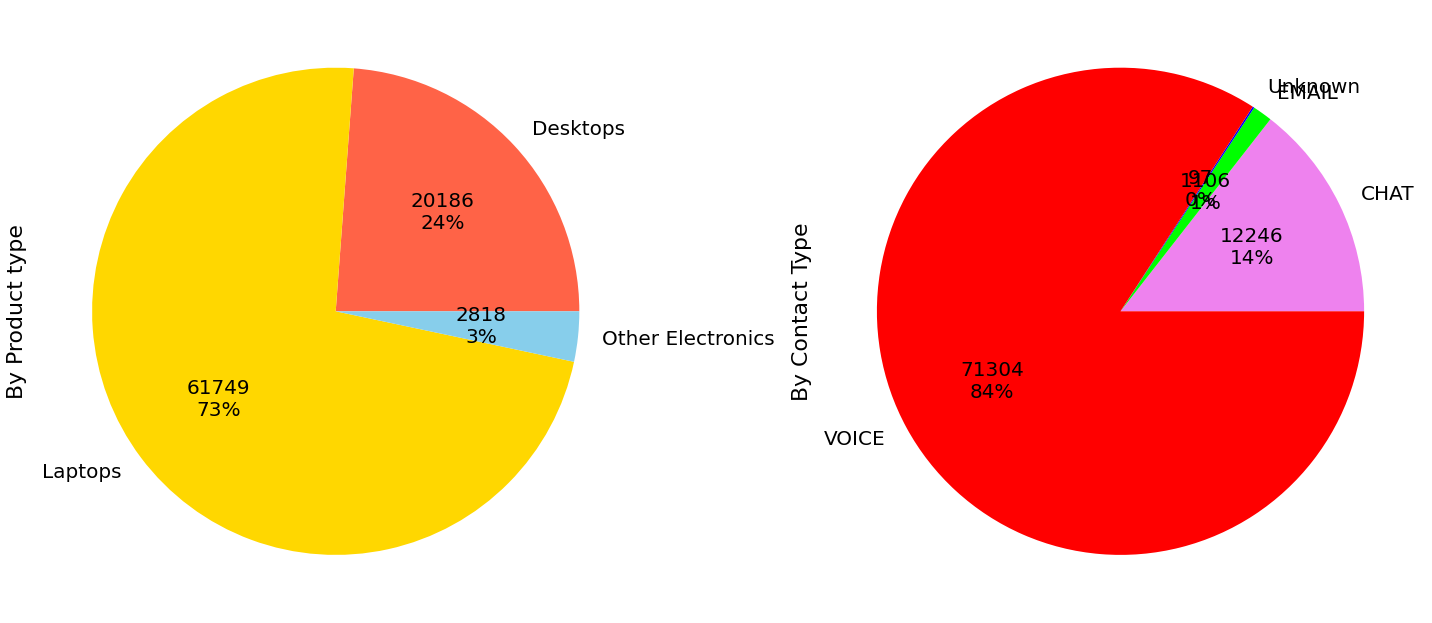

In [30]:
def label_function(val):
    return f'{val / 100 * len(df):.0f}\n{val:.0f}%'

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20,10))

df.groupby('product_type').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['tomato', 'gold', 'skyblue'], ax=ax1)

df.groupby('contact_type').size().plot(kind='pie', autopct=label_function, textprops={'fontsize': 20},
                                  colors=['violet', 'lime', 'blue', 'red',''], ax=ax2)

ax1.set_ylabel('By Product type', size=22)
ax2.set_ylabel('By Contact Type', size=22)
plt.tight_layout()
plt.show()

Another quick check we can do before starting analysis for specific category is finding overall mean, median and standard deviations of the contact days duration. I also graphed it for referrance.


In [32]:
# Checking overall mean and SD of the contact days
print('mean=%.3f, meadian=%.3f stdv=%.3f' % (np.mean(df['contact_days']), np.median(df['contact_days']), np.std(df['contact_days'])))

mean=662.557, meadian=511.000 stdv=577.832


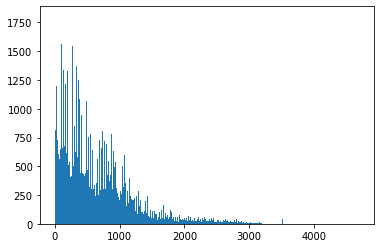

In [33]:
from matplotlib import pyplot

pyplot.hist(df['contact_days'], bins= 500)

pyplot.show()

For further analysis, we will take product_type = 'Laptops' as each product type will have its own analysis steps. 
1. Calculate top 3 issue_types occured for Laptops 
      - 'System Board Components', 'Audio, Video, Speakers, TV Tuner' and 'Fee Based Support'

In [34]:
df.loc[df['product_type'] == 'Laptops']

laptop_only = df[df['product_type'] == 'Laptops']

laptop_only.groupby(['issue_type']).size().sort_values(ascending=False).head(3)

issue_type
System Board Components             10648
Audio, Video, Speakers, TV Tuner     7590
Fee Based Support                    5690
dtype: int64

Maximum number of issues are registered under Booting category which requires mostly hard repairs with Motherboards as part sent frequently

In [35]:
c = laptop_only.groupby(['issue_type','topic_category']).size().nlargest(5)

c
#c.sort_values(ascending=False).head(3)

issue_type                        topic_category
System Board Components           Booting           6521
Audio, Video, Speakers, TV Tuner  LCD/Monitor       4514
Hard Drive                        Hard Drive        2669
Input Device / Webcam             Keyboard          2375
Operating System                  Booting           2111
dtype: int64

2. Calculate top 3 issue categories occured for Laptops 
      - Booting, LCD/Monitor, Call Logs 
      - This is required as issue_type can vary for same topic_category
      - User can think that the issue is related to the harddrive at the start but this can also be caused by faulty motherboard
      - This can be evident by looking at booting as topic category as it is used for issue_type as 'system Board Components' and 'Operating system'

In [36]:
laptop_only.groupby(['topic_category']).size().sort_values(ascending=False).head(3)

topic_category
Booting        19321
LCD/Monitor     5972
Call Logs       3623
dtype: int64

3. Calculating counts for Hard vs Soft repairs - Even though numbers are almost same, Hard repairs are more frequent

In [37]:
repair_ty_ct = laptop_only.groupby(['product_type','repair_type']).size()

repair_ty_ct.sort_values(ascending=False)

product_type  repair_type
Laptops       Hard           38517
              Soft           23232
dtype: int64



*   Now, We will take Laptop as product type and find average time user takes to call service center when they face booting issue.
*   We will only consider hard repairs as they are the most time and cost sensitive and need more preparations from support team





In [38]:
x = df[(df['product_type'] == 'Laptops') & (df['topic_category'] == 'Booting') & (df['repair_type'] == 'Hard')]

In [39]:
print('mean=%.3f, meadian=%.3f stdv=%.3f' % (np.mean(x['contact_days']), np.median(x['contact_days']), np.std(x['contact_days'])))

mean=581.137, meadian=490.000 stdv=403.282


From this plot we can see that data does not follow normal distribution and there are 3 peaks in the data distribution this might be because of the few factors which were not considered for ploting this graph. For Example, country or region can be a factor for different peaks of the data distribution. Product sold in region "Hogwards" can have components manufactured from place xyz which may have different warrenty and asset life than product manufactured from place abc.


  - After putting more filters and finding finding calls distribution, we can get a referance time frame ( mean +- S.D.) for issues. 
  - Understanding this distribution is really important as this we can setup hyperpersonalized marketing criteria to upsale new products.
  - We can also send a reminder notifications and quick issue resolution guide to customer based on mean contact days of the issue

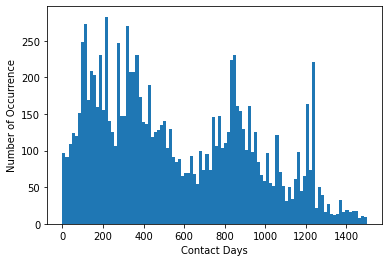

In [45]:
pyplot.hist(x['contact_days'], bins= 100, range=[0, 1500])

pyplot.xlabel('Contact Days')
pyplot.ylabel('Number of Occurrence')
pyplot.show()

Most of the Laptop issues are observed in Region Hogwards

In [52]:
laptop_only.groupby(['issue_type','topic_category','region']).size().sort_values(ascending=False)

issue_type                             topic_category     region   
System Board Components                Booting            Hogwarts     4768
Audio, Video, Speakers, TV Tuner       LCD/Monitor        Hogwarts     3428
Hard Drive                             Hard Drive         Hogwarts     2144
Operating System                       Booting            Hogwarts     1660
Power Subsystem / Cables / AC Adapter  Booting            Hogwarts     1494
                                                                       ... 
Fee Based Support                      SD Card            Hogwarts        1
                                       Mouse              Milky Way       1
                                       Microsoft Account  Milky Way       1
                                       Media              Milky Way       1
Adobe                                  Antivirus          Hogwarts        1
Length: 2098, dtype: int64



*   There are many more data analysis techniques can be applied on the data set. Such as KNN clustering to find out mean by K nearest neighbour.
*   Few things I can improve to find solutions for - 
    - accurate inventory forecast depending on type of hard issues and part requirements.
    - Forecast and management of human resources to better match customer behaviour and needs
*   Due to time constrain and simultaneous office work I could not put more hours on the data analysis part
*   Data cleaning part took most of the time. I could spend more time spending filling null values, rather than deleting lines.
*   Code can also be made more efficient with writing functions
*   Thank you giving me this opportunity to present my work.




